# Задание 3

Реализуйте регулеризованый LDA с двумя параметрами из лекции. Сравните его с логистической рергерссией (осуществите тюнинг гиперпараметров для обоих моделей) на публичных датасетах (хотя бы 5) из UCI (https://archive.ics.uci.edu/).

**Дополнительно**: постарайтесь найти датасеты, где LDA работает лучше и попробуйте объяснить почему.

Подсказка: если данных достаточно много, то LDA и LogReg не будут отличаться даже если предположения LDA выполняются - попробуйте уменьшать обучающую выборку чтобы найти ситуации, когда LDA работает лучше. Если не получается с публичными датасетами - сгенерируйте (в этом случае посчитайте bias и variance для LDA и LorReg).

In [189]:
import numpy as np

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt

from scipy import linalg

In [178]:
class RegularizedLDA:
    def __init__(self, n_components: int | None = None, alpha: float = 1.0, gamma: float = 1.0):
        """
        Regularized Linear Discriminant Analysis (RLDA) is a supervised dimensionality reduction technique that
        generalizes Linear Discriminant Analysis (LDA) by adding regularization terms to the within-class scatter matrix.
        (Sigma_hat_k = alpha * Sigma_k + (1 - alpha) * Sigma_hat | Sigma_hat = gamma * Sigma + (1 - gamma) * I * sigma^2)

        :param n_components: Number of components to keep. If None, it will be set to min(n_classes - 1, n_features)
        :param alpha: Regularization parameter for within-class scatter matrix (1 means no regularization)
        :param gamma: Regularization parameter for within and between-class scatter matrices (1 means no regularization)
        """

        self.n_components = n_components

        self.alpha = alpha
        self.gamma = gamma

        self.weights = None
        self.bias = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the model with the given training data.

        :param X: Training data
        :param y: Target values
        """

        n_samples, n_features = X.shape
        classes, cls_counts = np.unique(y, return_counts=True)
        pi_k = cls_counts / n_samples

        # Selecting the number of components (if not specified)
        if self.n_components is None:
            self.n_components = min(classes.size - 1, n_features)

        mu_k = np.array([X[y == cls].mean(axis=0) for cls in classes])
        between_cls_deviation = mu_k - X.mean(axis=0)
        within_cls_deviation = X - mu_k[y]

        # Calculating the weights and bias
        sigam_classes = pi_k * between_cls_deviation.T @ between_cls_deviation # Between-class scatter matrix | Sigma
        sigma_all = within_cls_deviation.T @ within_cls_deviation / n_samples # Covariance matrix | sum of all Sigma_k

        # Regularizing the scatter matrices
        sigma_all = self.gamma * sigma_all + (1 - self.gamma) * np.eye(n_features) * np.trace(sigma_all) / n_features
        sigam_classes = self.alpha * sigam_classes + (1 - self.alpha) * sigma_all
        
        evals, evecs = linalg.eigh(sigam_classes, sigma_all)
        dvecs = evecs[:, np.argsort(evals)[::-1]]

        dvecs = dvecs[:, :self.n_components]

        # Finding the weights and bias (delta = X @ weights + bias)
        self.weights = mu_k @ dvecs @ dvecs.T
        self.bias = np.log(pi_k) - 0.5 * np.diag(self.weights @ mu_k.T)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.weights is None or self.bias is None:
            raise ValueError("Model is not fitted")

        deltas = X_test @ self.weights.T + self.bias
        classes = np.argmax(deltas, axis=1)

        return classes

In [77]:
# Download the dataset

iris = fetch_ucirepo(id=53) # 150 Instances, 4 Features
wine = fetch_ucirepo(id=109) # 178 Instances, 13 Features
heart_failure_clinical_records = fetch_ucirepo(id=519) # 299 Instances, 12 Features
glass_identification = fetch_ucirepo(id=42) # 214 Instances, 9 Features

predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) # 4.42K Instances, 36 Features

wine_quality = fetch_ucirepo(id=186) # 4.9K Instances, 11 Features
abalone = fetch_ucirepo(id=1) # 4.17K Instances, 8 Features

In [100]:
# Preprocess the data

iris.data.targets = LabelEncoder().fit_transform(iris.data.targets)
wine.data.targets = LabelEncoder().fit_transform(wine.data.targets)
heart_failure_clinical_records.data.targets = LabelEncoder().fit_transform(heart_failure_clinical_records.data.targets)
glass_identification.data.targets = LabelEncoder().fit_transform(glass_identification.data.targets)

predict_students_dropout_and_academic_success.data.targets = \
    LabelEncoder().fit_transform(predict_students_dropout_and_academic_success.data.targets)

wine_quality.data.targets = LabelEncoder().fit_transform(wine_quality.data.targets)
abalone.data.targets = LabelEncoder().fit_transform(abalone.data.targets)

abalone.data.features["Sex"] = LabelEncoder().fit_transform(abalone.data.features["Sex"])

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\setday\AppData\Local\Temp\ipykernel_3128\1830312978.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abalone.data.features["Sex"] = LabelEncoder().fit_transform(abalone.data.features["Sex"])


In [120]:
def test_on_real_data(model, data):
    """
    Test the model on real data
    :param model: model to test
    :param data: data to test on
    """

    X = data.data.features.to_numpy()
    y = data.data.targets

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # print(y_pred)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")

@ignore_warnings(category=ConvergenceWarning)
def test_on_selected_datasets(model):
    """
    Test the model on selected datasets
    :param model: model class to test
    """

    print("Testing on iris dataset:", end=" ")
    test_on_real_data(model, iris)
    print("Testing on wine dataset:", end=" ")
    test_on_real_data(model, wine)
    print("Testing on heart_failure_clinical_records dataset:", end=" ")
    test_on_real_data(model, heart_failure_clinical_records)
    print("Testing on glass_identification dataset:", end=" ")
    test_on_real_data(model, glass_identification)

    print("Testing on predict_students_dropout_and_academic_success dataset:", end=" ")
    test_on_real_data(model, predict_students_dropout_and_academic_success)

    print("Testing on wine_quality dataset:", end=" ")
    test_on_real_data(model, wine_quality)
    print("Testing on abalone dataset:", end=" ")
    test_on_real_data(model, abalone)

In [181]:
test_on_selected_datasets(LogisticRegression(max_iter=1000))

Testing on iris dataset: Accuracy: 1.00
Testing on wine dataset: Accuracy: 1.00
Testing on heart_failure_clinical_records dataset: Accuracy: 0.79
Testing on glass_identification dataset: Accuracy: 0.66
Testing on predict_students_dropout_and_academic_success dataset: Accuracy: 0.72
Testing on wine_quality dataset: Accuracy: 0.52
Testing on abalone dataset: Accuracy: 0.26


In [179]:
test_on_selected_datasets(RegularizedLDA(alpha=0.9, gamma=0.9))

Testing on iris dataset: Accuracy: 1.00
Testing on wine dataset: Accuracy: 0.76
Testing on heart_failure_clinical_records dataset: Accuracy: 0.59
Testing on glass_identification dataset: Accuracy: 0.62
Testing on predict_students_dropout_and_academic_success dataset: Accuracy: 0.48
Testing on wine_quality dataset: Accuracy: 0.46
Testing on abalone dataset: Accuracy: 0.26


In [180]:
test_on_selected_datasets(RegularizedLDA(alpha=1, gamma=1))

Testing on iris dataset: Accuracy: 1.00
Testing on wine dataset: Accuracy: 1.00
Testing on heart_failure_clinical_records dataset: Accuracy: 0.81
Testing on glass_identification dataset: Accuracy: 0.62
Testing on predict_students_dropout_and_academic_success dataset: Accuracy: 0.75
Testing on wine_quality dataset: Accuracy: 0.54
Testing on abalone dataset: Accuracy: 0.25


Регуляризация работает не очень, т.к. в датасетах количтсво классов примерно сбалансированно (обычно регуляризация помагает только когда в какой-то классе примеров меньше или спостовимо с числом предикторов). 

Кроме того, LDA дал более хорошие результаты на `heart_failure_clinical_records` и `predict_students_dropout_and_academic_success`.

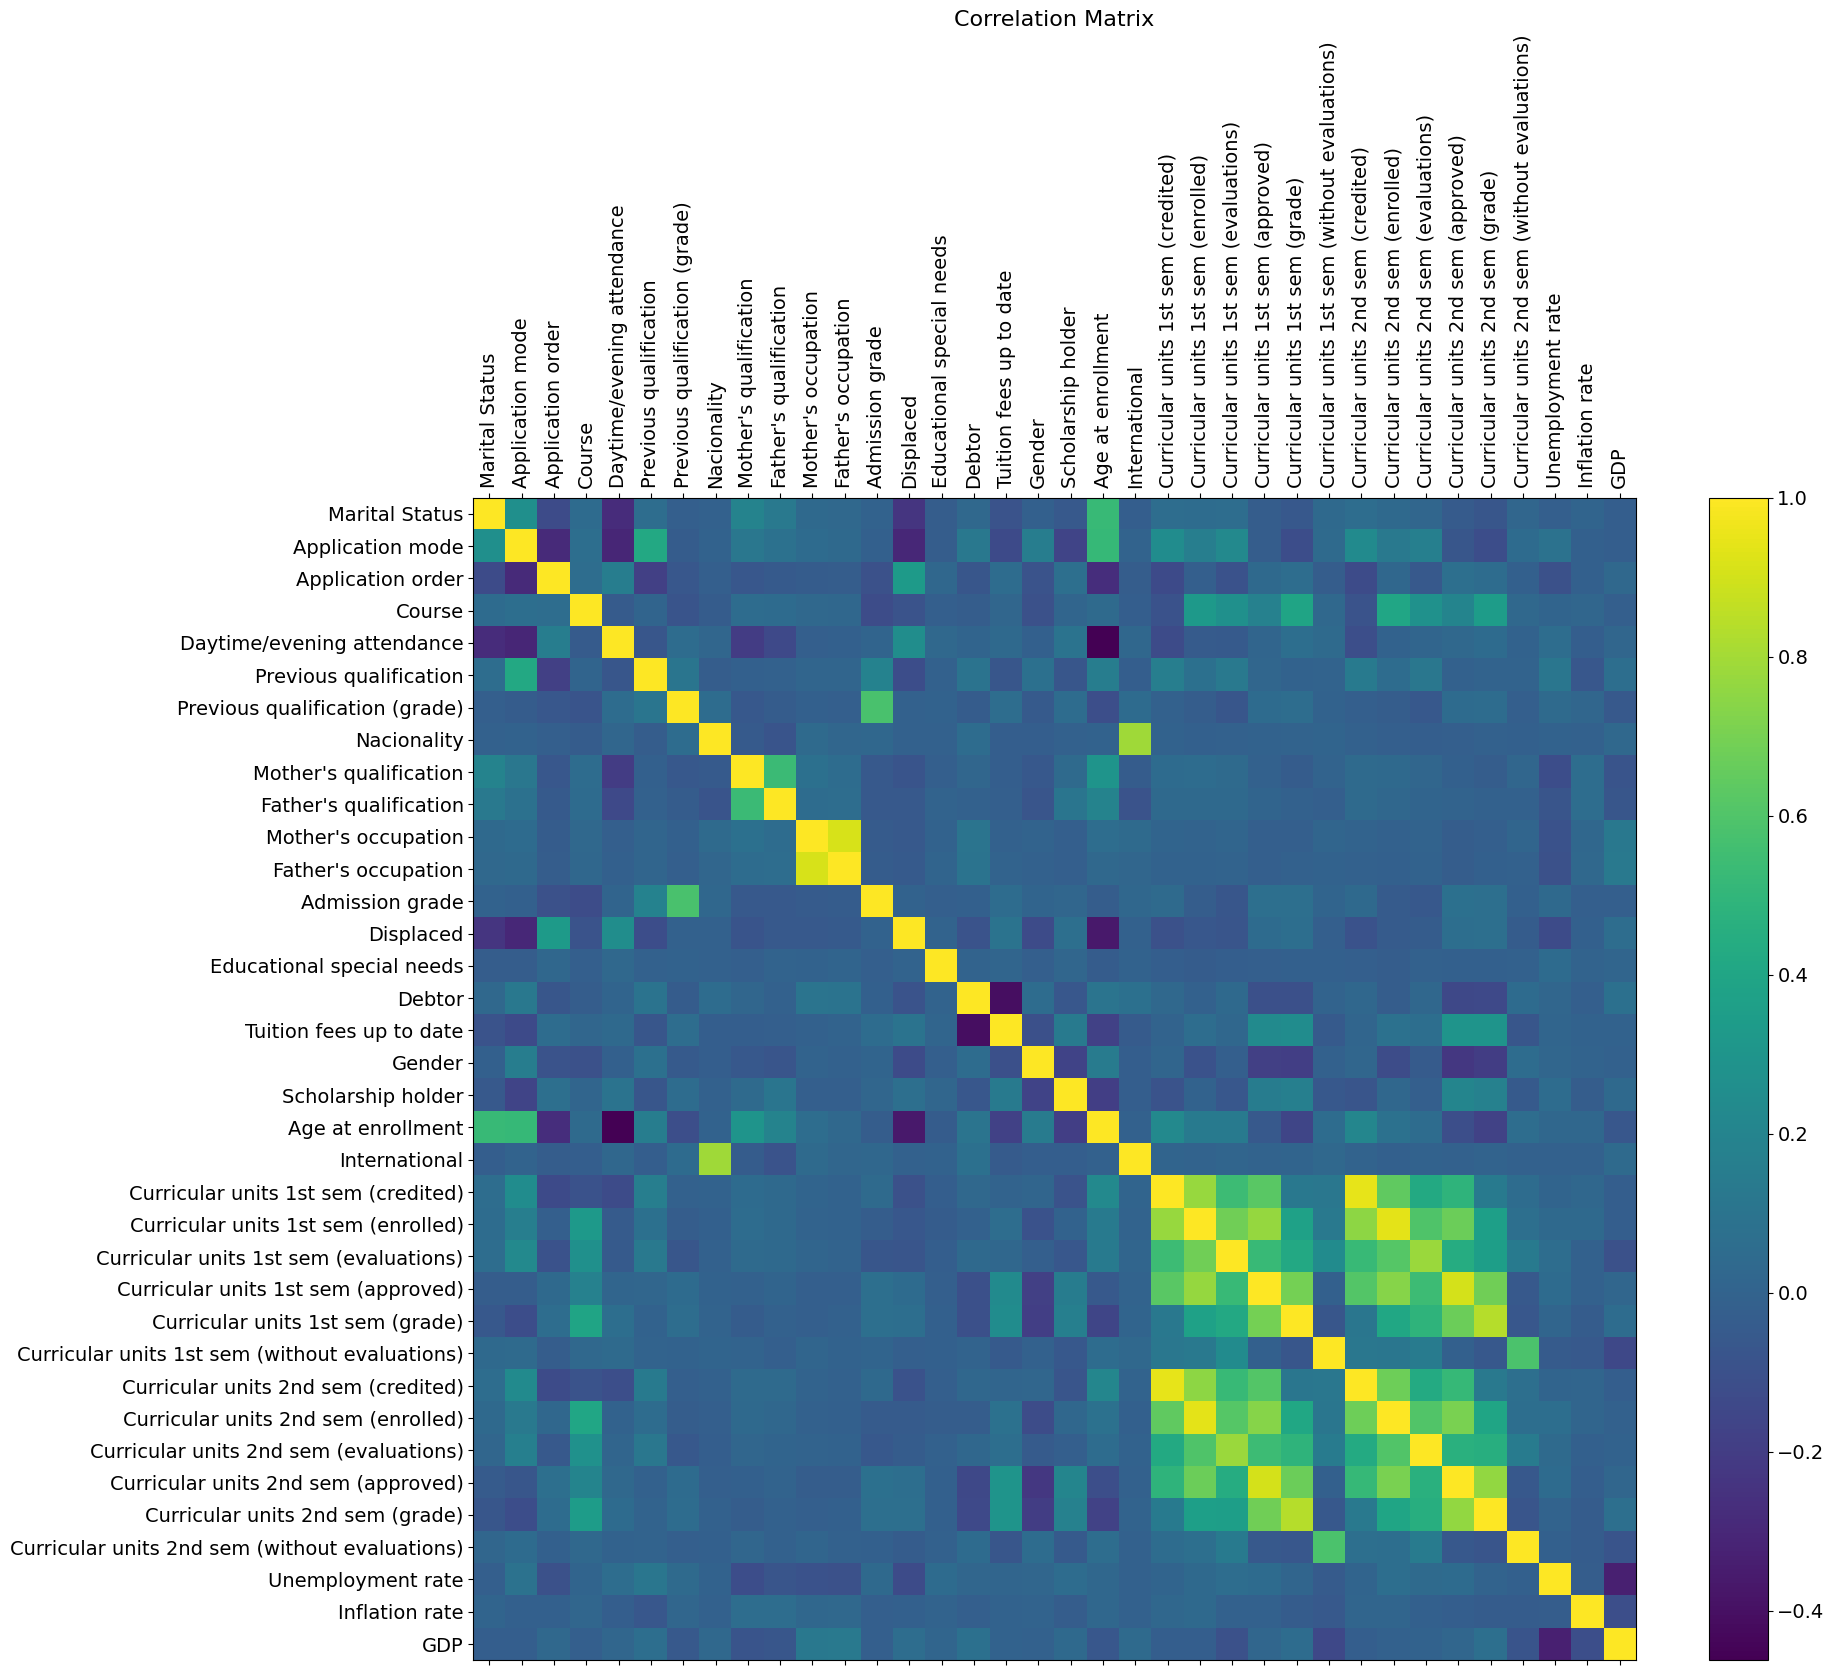

In [199]:
def visualize_corr(df):
    f = plt.figure(figsize=(19, 15))

    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()

visualize_corr(predict_students_dropout_and_academic_success.data.features)

Не сложно заметить довольно сильную корреляцию, что мешает `LogisticRegression` в `predict_students_dropout_and_academic_success`.

`heart_failure_clinical_records` довольно мал и имеет "большое" число предикторов, из-за чего `LDA` справляется лучше.